<h1>DENSENET<H1>

In [1]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
# Set paths
train_dir = 'E:/finaltrail/train'
test_dir = 'E:/finaltrail/test'

In [3]:
# Load pre-trained DenseNet121 model without the top layer (used for feature extraction)
densenet_model = DenseNet121(include_top=False, input_shape=(224, 224, 3), pooling='avg')

# Extract features function
def extract_features_with_model(model, directory, sample_count, batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    features = []
    labels = []
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features.append(features_batch)
        labels.append(labels_batch)
        if len(features) * batch_size >= sample_count:
            break

    features = np.vstack(features)[:sample_count]
    labels = np.vstack(labels)[:sample_count]
    return features, labels

# Extract features using DenseNet121
densenet_train_features, train_labels = extract_features_with_model(densenet_model, train_dir, 4000)
densenet_test_features, test_labels = extract_features_with_model(densenet_model, test_dir, 1000)

# Save extracted features
joblib.dump((densenet_train_features, train_labels, densenet_test_features, test_labels), 'densenet_features.joblib')

# Load features
densenet_train_features, train_labels, densenet_test_features, test_labels = joblib.load('densenet_features.joblib')

# Define DenseNet121-based model with additional layers
densenet_classifier = Sequential([
    Dense(1024, activation='relu', input_shape=(1024,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(5, activation='softmax')
])

densenet_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Found 4408 images belonging to 5 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━

C:\Users\ramav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Callbacks for early stopping and model saving
densenet_checkpoint = ModelCheckpoint('densenet_best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)

# Train the DenseNet model
densenet_history = densenet_classifier.fit(
    densenet_train_features, train_labels,
    epochs=50,
    validation_data=(densenet_test_features, test_labels),
    callbacks=[densenet_checkpoint, early_stop]
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.6172 - loss: 1.0811 - val_accuracy: 0.7760 - val_loss: 0.5838
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8182 - loss: 0.5019 - val_accuracy: 0.8520 - val_loss: 0.4029
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8368 - loss: 0.4447 - val_accuracy: 0.8510 - val_loss: 0.3903
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8577 - loss: 0.3831 - val_accuracy: 0.8440 - val_loss: 0.4091
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8691 - loss: 0.3607 - val_accuracy: 0.8640 - val_loss: 0.3695
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8867 - loss: 0.3129 - val_accuracy: 0.8720 - val_loss: 0.3472
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8878 - loss: 0.2974 - val_accuracy: 0.8550 - val_loss: 0.4240
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9039 - loss: 0.2791 - val_ac

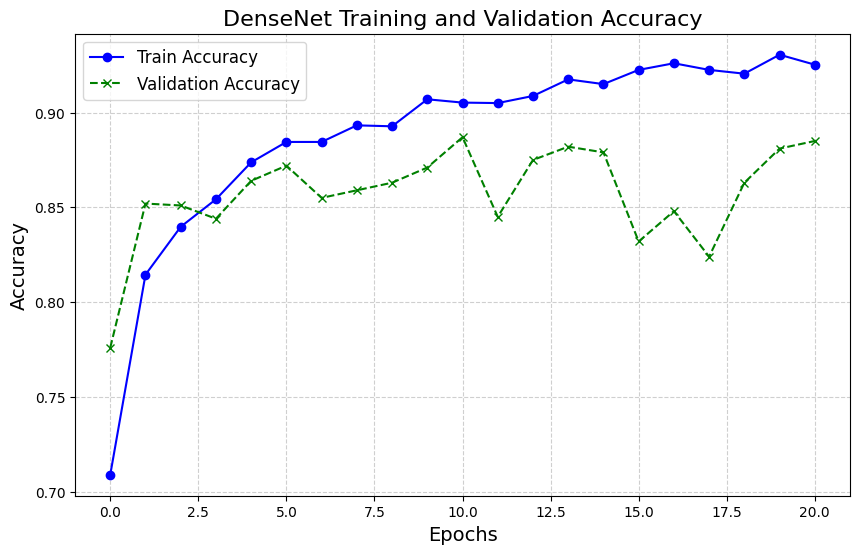

In [5]:
# Plotting accuracy graphs for DenseNet
plt.figure(figsize=(10, 6))  # Increase figure size for better clarity
plt.plot(densenet_history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='-', marker='o')
plt.plot(densenet_history.history['val_accuracy'], label='Validation Accuracy', color='green', linestyle='--', marker='x')
plt.title('DenseNet Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)  # Add a grid for better readability
plt.show()

In [6]:
# Classification Report for DenseNet
densenet_predictions = densenet_classifier.predict(densenet_test_features)
densenet_pred_labels = densenet_predictions.argmax(axis=1)
print("DenseNet Classification Report:")
print(classification_report(test_labels.argmax(axis=1), densenet_pred_labels, target_names=['Broken', 'Immature', 'Intact', 'Skin-Damaged', 'Spotted']))


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
DenseNet Classification Report:
              precision    recall  f1-score   support

      Broken       0.84      0.87      0.86       201
    Immature       0.96      0.88      0.92       225
      Intact       0.90      0.93      0.91       241
Skin-Damaged       0.84      0.92      0.88       226
     Spotted       0.91      0.79      0.84       107

    accuracy                           0.89      1000
   macro avg       0.89      0.88      0.88      1000
weighted avg       0.89      0.89      0.89      1000



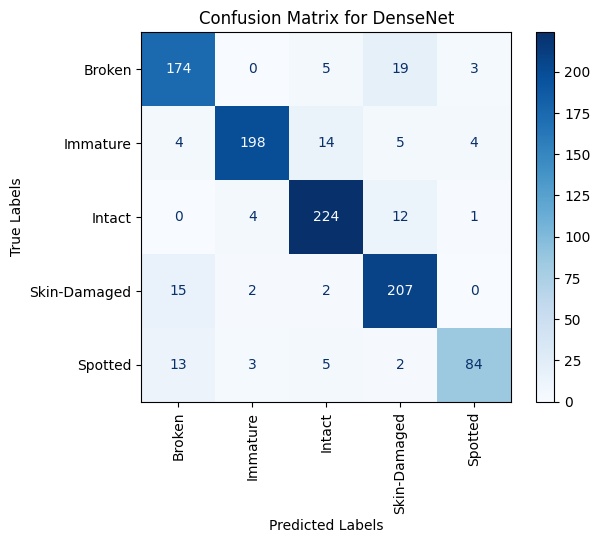

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), densenet_pred_labels)

# Define class names (adjust according to your classes)
class_names = ['Broken', 'Immature', 'Intact', 'Skin-Damaged', 'Spotted']

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')

# Add title and labels
plt.title("Confusion Matrix for DenseNet")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Show the plot
plt.show()